In [12]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.7 MB/s eta 0:00:0000:01


In [1]:
import os

def list_files(startpath):
    print(f"Listing directory structure for: {startpath}\n")
    for root, dirs, files in os.walk(startpath):
        # Calculate depth for indentation
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f"{indent}📁 {os.path.basename(root)}/")
        subindent = ' ' * 4 * (level + 1)
        # Limit file display if there are too many (e.g., in a dataset)
        if len(files) > 10:
            for f in files[:5]:
                print(f"{subindent}📄 {f}")
            print(f"{subindent}... and {len(files)-5} more files.")
        else:
            for f in files:
                print(f"{subindent}📄 {f}")

# 1. Check your attached datasets (Input)
if os.path.exists('/kaggle/input'):
    list_files('/kaggle/input')
else:
    print("No datasets attached to /kaggle/input yet.")

print("\n" + "="*50 + "\n")

# 2. Check your workspace (Working)
list_files('/kaggle/working')

Listing directory structure for: /kaggle/input

📁 input/
    📁 pcb-defects/
        📁 PCB_DATASET/
            📄 rotate.py
            📁 PCB_USED/
                📄 10.JPG
                📄 01.JPG
                📄 09.JPG
                📄 05.JPG
                📄 06.JPG
                📄 04.JPG
                📄 12.JPG
                📄 11.JPG
                📄 08.JPG
                📄 07.JPG
            📁 Annotations/
                📁 Mouse_bite/
                    📄 01_mouse_bite_11.xml
                    📄 01_mouse_bite_17.xml
                    📄 08_mouse_bite_08.xml
                    📄 08_mouse_bite_02.xml
                    📄 07_mouse_bite_03.xml
                    ... and 110 more files.
                📁 Spur/
                    📄 09_spur_04.xml
                    📄 10_spur_01.xml
                    📄 12_spur_03.xml
                    📄 10_spur_03.xml
                    📄 09_spur_07.xml
                    ... and 110 more files.
                📁 Open_circuit/
  

# pre process

In [2]:
import os
import xml.etree.ElementTree as ET
import shutil
from tqdm import tqdm

# Define the paths based on your directory walk
INPUT_DIR = "/kaggle/input/pcb-defects/PCB_DATASET"
WORKING_DIR = "/kaggle/working/pcb_real_world"

# The 6 industrial classes in your dataset
CLASSES = ['Mouse_bite', 'Spur', 'Open_circuit', 'Short', 'Missing_hole', 'Spurious_copper']
class_map = {name: i for i, name in enumerate(CLASSES)}

# Create the folder structure YOLO expects
for split in ['train', 'val']:
    os.makedirs(f"{WORKING_DIR}/images/{split}", exist_ok=True)
    os.makedirs(f"{WORKING_DIR}/labels/{split}", exist_ok=True)

def convert_to_yolo(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    return (x * dw, y * dh, w * dw, h * dh)

# Process all folders
all_pairs = []
for cls in CLASSES:
    img_folder = f"{INPUT_DIR}/images/{cls}"
    ann_folder = f"{INPUT_DIR}/Annotations/{cls}"
    if not os.path.exists(img_folder): continue
    
    images = [f for f in os.listdir(img_folder) if f.endswith('.jpg')]
    for img_name in images:
        xml_name = img_name.replace('.jpg', '.xml')
        if os.path.exists(os.path.join(ann_folder, xml_name)):
            all_pairs.append((os.path.join(img_folder, img_name), os.path.join(ann_folder, xml_name)))

# Split 80% Train / 20% Val
split_idx = int(len(all_pairs) * 0.8)
datasets = {'train': all_pairs[:split_idx], 'val': all_pairs[split_idx:]}

for split, pairs in datasets.items():
    for img_path, xml_path in tqdm(pairs, desc=f"Converting {split}"):
        tree = ET.parse(xml_path)
        root = tree.getroot()
        size = root.find('size')
        w, h = int(size.find('width').text), int(size.find('height').text)
        
        yolo_lines = []
        for obj in root.findall('object'):
            name = obj.find('name').text
            # Handle naming inconsistencies (spaces vs underscores)
            mapped_name = name.replace(" ", "_")
            if mapped_name not in class_map: continue
            
            bbox = obj.find('bndbox')
            b = (float(bbox.find('xmin').text), float(bbox.find('xmax').text), 
                 float(bbox.find('ymin').text), float(bbox.find('ymax').text))
            bb = convert_to_yolo((w, h), b)
            yolo_lines.append(f"{class_map[mapped_name]} " + " ".join([f"{a:.6f}" for a in bb]))
        
        if yolo_lines:
            shutil.copy(img_path, f"{WORKING_DIR}/images/{split}/{os.path.basename(img_path)}")
            with open(f"{WORKING_DIR}/labels/{split}/{os.path.basename(img_path).replace('.jpg', '.txt')}", 'w') as f:
                f.write("\n".join(yolo_lines))

print(f"✅ Step 1 Complete: Dataset ready in {WORKING_DIR}")

Converting val: 100%|██████████| 139/139 [00:00<00:00, 193.87it/s]

✅ Step 1 Complete: Dataset ready in /kaggle/working/pcb_real_world


In [3]:
import os

def check_dir(path):
    files = os.listdir(path)
    print(f"📂 {path}: {len(files)} files found.")
    if len(files) > 0:
        print(f"   First 3 samples: {files[:3]}")

print("🔍 VERIFYING DATASET STRUCTURE:")
check_dir("/kaggle/working/pcb_real_world/images/train")
check_dir("/kaggle/working/pcb_real_world/labels/train")
check_dir("/kaggle/working/pcb_real_world/images/val")
check_dir("/kaggle/working/pcb_real_world/labels/val")

# Check if a label exists for the first image
sample_img = os.listdir("/kaggle/working/pcb_real_world/images/train")[0]
sample_lbl = sample_img.replace(".jpg", ".txt")
lbl_path = f"/kaggle/working/pcb_real_world/labels/train/{sample_lbl}"

if os.path.exists(lbl_path):
    print(f"\n✅ MATCH FOUND: Image '{sample_img}' has a matching label file.")
else:
    print(f"\n❌ ERROR: Label missing for '{sample_img}' at {lbl_path}")

🔍 VERIFYING DATASET STRUCTURE:
📂 /kaggle/working/pcb_real_world/images/train: 0 files found.
📂 /kaggle/working/pcb_real_world/labels/train: 0 files found.
📂 /kaggle/working/pcb_real_world/images/val: 0 files found.
📂 /kaggle/working/pcb_real_world/labels/val: 0 files found.


IndexError: list index out of range

# Forced data conversion

In [4]:
import os
import xml.etree.ElementTree as ET
import shutil
from tqdm import tqdm

INPUT_DIR = "/kaggle/input/pcb-defects/PCB_DATASET"
WORKING_DIR = "/kaggle/working/pcb_real_world"

CLASSES = ['Mouse_bite', 'Spur', 'Open_circuit', 'Short', 'Missing_hole', 'Spurious_copper']
class_map = {name: i for i, name in enumerate(CLASSES)}

# Clean and Create folders
if os.path.exists(WORKING_DIR): shutil.rmtree(WORKING_DIR)
for split in ['train', 'val']:
    os.makedirs(f"{WORKING_DIR}/images/{split}", exist_ok=True)
    os.makedirs(f"{WORKING_DIR}/labels/{split}", exist_ok=True)

def convert_to_yolo(size, box):
    dw, dh = 1. / size[0], 1. / size[1]
    return ((box[0] + box[1]) / 2.0 * dw, (box[2] + box[3]) / 2.0 * dh, 
            (box[1] - box[0]) * dw, (box[3] - box[2]) * dh)

all_pairs = []

# 1. Search for files with multiple extension types
for cls in CLASSES:
    img_folder = os.path.join(INPUT_DIR, "images", cls)
    ann_folder = os.path.join(INPUT_DIR, "Annotations", cls)
    
    if not os.path.exists(img_folder):
        print(f"⚠️ Folder missing: {img_folder}")
        continue
    
    # Look for .jpg, .JPG, .jpeg
    files = [f for f in os.listdir(img_folder) if f.lower().endswith(('.jpg', '.jpeg'))]
    print(f"📁 Found {len(files)} images in {cls}")
    
    for img_name in files:
        # Match XML (usually same name as image)
        xml_name = os.path.splitext(img_name)[0] + ".xml"
        xml_path = os.path.join(ann_folder, xml_name)
        
        if os.path.exists(xml_path):
            all_pairs.append((os.path.join(img_folder, img_name), xml_path))

print(f"\n🚀 Total valid pairs identified: {len(all_pairs)}")

# 2. Perform the copy and conversion
split_idx = int(len(all_pairs) * 0.8)
datasets = {'train': all_pairs[:split_idx], 'val': all_pairs[split_idx:]}

for split, pairs in datasets.items():
    for img_path, xml_path in tqdm(pairs, desc=f"Writing {split}"):
        try:
            tree = ET.parse(xml_path)
            root = tree.getroot()
            size = root.find('size')
            w, h = int(size.find('width').text), int(size.find('height').text)
            
            yolo_lines = []
            for obj in root.findall('object'):
                name = obj.find('name').text.replace(" ", "_")
                if name not in class_map: continue
                
                bbox = obj.find('bndbox')
                b = (float(bbox.find('xmin').text), float(bbox.find('xmax').text), 
                     float(bbox.find('ymin').text), float(bbox.find('ymax').text))
                bb = convert_to_yolo((w, h), b)
                yolo_lines.append(f"{class_map[name]} " + " ".join([f"{a:.6f}" for a in bb]))
            
            if yolo_lines:
                # Use standard lowercase extension for the copy to keep YOLO happy
                new_img_name = os.path.splitext(os.path.basename(img_path))[0] + ".jpg"
                shutil.copy(img_path, os.path.join(WORKING_DIR, "images", split, new_img_name))
                with open(os.path.join(WORKING_DIR, "labels", split, new_img_name.replace(".jpg", ".txt")), 'w') as f:
                    f.write("\n".join(yolo_lines))
        except Exception as e:
            pass

print(f"\n✅ Step 1 Re-attempt Complete. Ready for verification.")

📁 Found 115 images in Mouse_bite
📁 Found 115 images in Spur
📁 Found 116 images in Open_circuit
📁 Found 116 images in Short
📁 Found 115 images in Missing_hole
📁 Found 116 images in Spurious_copper

🚀 Total valid pairs identified: 693


Writing val: 100%|██████████| 139/139 [00:00<00:00, 1432.48it/s]


✅ Step 1 Re-attempt Complete. Ready for verification.


In [5]:
import os
print(f"✅ Images in Train: {len(os.listdir('/kaggle/working/pcb_real_world/images/train'))}")
print(f"✅ Labels in Train: {len(os.listdir('/kaggle/working/pcb_real_world/labels/train'))}")

✅ Images in Train: 0
✅ Labels in Train: 0


In [6]:
import os
import xml.etree.ElementTree as ET
import shutil
from tqdm import tqdm

INPUT_DIR = "/kaggle/input/pcb-defects/PCB_DATASET"
WORKING_DIR = "/kaggle/working/pcb_real_world"

# Define the 6 classes as they appear in the XML 'name' tags
CLASSES = ['Mouse_bite', 'Spur', 'Open_circuit', 'Short', 'Missing_hole', 'Spurious_copper']
class_map = {name: i for i, name in enumerate(CLASSES)}

# 1. HARD RESET: Wipe and Recreate
if os.path.exists(WORKING_DIR):
    shutil.rmtree(WORKING_DIR)

for split in ['train', 'val']:
    os.makedirs(f"{WORKING_DIR}/images/{split}", exist_ok=True)
    os.makedirs(f"{WORKING_DIR}/labels/{split}", exist_ok=True)

def convert_to_yolo(size, box):
    dw, dh = 1. / size[0], 1. / size[1]
    xc = (box[0] + box[1]) / 2.0 * dw
    yc = (box[2] + box[3]) / 2.0 * dh
    w = (box[1] - box[0]) * dw
    h = (box[3] - box[2]) * dh
    return (xc, yc, w, h)

# 2. COLLECT DATA
all_pairs = []
for cls in CLASSES:
    img_folder = f"{INPUT_DIR}/images/{cls}"
    ann_folder = f"{INPUT_DIR}/Annotations/{cls}"
    
    if not os.path.exists(img_folder): continue
    
    # Get all .jpg and .JPG files
    img_files = [f for f in os.listdir(img_folder) if f.lower().endswith(('.jpg', '.jpeg'))]
    
    for img_name in img_files:
        xml_name = os.path.splitext(img_name)[0] + ".xml"
        xml_path = os.path.join(ann_folder, xml_name)
        if os.path.exists(xml_path):
            all_pairs.append((os.path.join(img_folder, img_name), xml_path))

# 3. SPLIT & EXECUTE (80/20 split)
split_idx = int(len(all_pairs) * 0.8)
split_map = {'train': all_pairs[:split_idx], 'val': all_pairs[split_idx:]}

print(f"📊 Identified {len(all_pairs)} pairs. Starting file movement...")

for split, pairs in split_map.items():
    success_count = 0
    for img_path, xml_path in pairs:
        try:
            # Parse XML
            tree = ET.parse(xml_path)
            root = tree.getroot()
            size = root.find('size')
            w, h = int(size.find('width').text), int(size.find('height').text)
            
            yolo_lines = []
            for obj in root.findall('object'):
                name = obj.find('name').text.replace(" ", "_")
                if name not in class_map: continue
                
                bbox = obj.find('bndbox')
                # Important: Some XMLs use xmin/ymin, ensure we get floats
                b = (float(bbox.find('xmin').text), float(bbox.find('xmax').text), 
                     float(bbox.find('ymin').text), float(bbox.find('ymax').text))
                
                bb = convert_to_yolo((w, h), b)
                yolo_lines.append(f"{class_map[name]} " + " ".join([f"{a:.6f}" for a in bb]))
            
            if yolo_lines:
                # Copy Image
                fname = os.path.basename(img_path)
                dest_img = f"{WORKING_DIR}/images/{split}/{fname}"
                shutil.copy2(img_path, dest_img) # copy2 preserves metadata
                
                # Write Label
                dest_lbl = f"{WORKING_DIR}/labels/{split}/{os.path.splitext(fname)[0]}.txt"
                with open(dest_lbl, 'w') as f:
                    f.write("\n".join(yolo_lines))
                
                success_count += 1
        except Exception as e:
            pass
    print(f"✅ Finished {split}: Successfully created {success_count} Image/Label pairs.")

print("\n--- FINAL VERIFICATION ---")
print(f"Train Images: {len(os.listdir(f'{WORKING_DIR}/images/train'))}")
print(f"Train Labels: {len(os.listdir(f'{WORKING_DIR}/labels/train'))}")

📊 Identified 693 pairs. Starting file movement...
✅ Finished train: Successfully created 0 Image/Label pairs.
✅ Finished val: Successfully created 0 Image/Label pairs.

--- FINAL VERIFICATION ---
Train Images: 0
Train Labels: 0


In [7]:
import os

# 1. Let's look at the exact filenames in one folder
sample_cls = 'Mouse_bite'
img_path = f"/kaggle/input/pcb-defects/PCB_DATASET/images/{sample_cls}"
ann_path = f"/kaggle/input/pcb-defects/PCB_DATASET/Annotations/{sample_cls}"

print(f"📂 Checking {sample_cls} images:")
if os.path.exists(img_path):
    print(f"   Files: {os.listdir(img_path)[:5]}")
else:
    print("   ❌ Image path not found!")

print(f"\n📂 Checking {sample_cls} annotations:")
if os.path.exists(ann_path):
    xml_files = os.listdir(ann_path)
    print(f"   Files: {xml_files[:5]}")
    
    # 2. Print the content of one XML to see the tags
    if len(xml_files) > 0:
        with open(os.path.join(ann_path, xml_files[0]), 'r') as f:
            print(f"\n📄 Content of {xml_files[0]}:\n")
            print(f.read())
else:
    print("   ❌ Annotation path not found!")

📂 Checking Mouse_bite images:
   Files: ['01_mouse_bite_20.jpg', '04_mouse_bite_16.jpg', '12_mouse_bite_06.jpg', '04_mouse_bite_11.jpg', '06_mouse_bite_04.jpg']

📂 Checking Mouse_bite annotations:
   Files: ['01_mouse_bite_11.xml', '01_mouse_bite_17.xml', '08_mouse_bite_08.xml', '08_mouse_bite_02.xml', '07_mouse_bite_03.xml']

📄 Content of 01_mouse_bite_11.xml:

<annotation>
	<folder>Mouse_bite</folder>
	<filename>01_mouse_bite_11.jpg</filename>
	<path>/home/weapon/Desktop/PCB_DATASET/Mouse_bite/01_mouse_bite_11.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>3034</width>
		<height>1586</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>mouse_bite</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>1199</xmin>
			<ymin>966</ymin>
			<xmax>1234</xmax>
			<ymax>1004</ymax>
		</bndbox>
	</object>
	<object>
		<name>mouse_bite</name>
		<pose>Unspecified</pose>
		<truncated>0

In [8]:
import os
import xml.etree.ElementTree as ET
import shutil
from tqdm import tqdm

INPUT_DIR = "/kaggle/input/pcb-defects/PCB_DATASET"
WORKING_DIR = "/kaggle/working/pcb_real_world"

# Normalized class list to match your XML <name> tags
CLASSES = ['mouse_bite', 'spur', 'open_circuit', 'short', 'missing_hole', 'spurious_copper']
class_map = {name: i for i, name in enumerate(CLASSES)}

if os.path.exists(WORKING_DIR):
    shutil.rmtree(WORKING_DIR)

for split in ['train', 'val']:
    os.makedirs(f"{WORKING_DIR}/images/{split}", exist_ok=True)
    os.makedirs(f"{WORKING_DIR}/labels/{split}", exist_ok=True)

def convert_to_yolo(size, box):
    dw, dh = 1. / size[0], 1. / size[1]
    xc = (box[0] + box[1]) / 2.0 * dw
    yc = (box[2] + box[3]) / 2.0 * dh
    w = (box[1] - box[0]) * dw
    h = (box[3] - box[2]) * dh
    return (xc, yc, w, h)

all_pairs = []
# Re-mapping the folder search to use the actual directory names provided in your walk
FOLDER_NAMES = ['Mouse_bite', 'Spur', 'Open_circuit', 'Short', 'Missing_hole', 'Spurious_copper']

for folder in FOLDER_NAMES:
    img_folder = f"{INPUT_DIR}/images/{folder}"
    ann_folder = f"{INPUT_DIR}/Annotations/{folder}"
    
    if not os.path.exists(img_folder): continue
    
    for img_name in os.listdir(img_folder):
        if img_name.lower().endswith('.jpg'):
            # The XML might not have the exact same filename as the JPG in this dataset
            # We look for the XML that matches the image name
            xml_name = os.path.splitext(img_name)[0] + ".xml"
            xml_path = os.path.join(ann_folder, xml_name)
            
            if os.path.exists(xml_path):
                all_pairs.append((os.path.join(img_folder, img_name), xml_path))

split_idx = int(len(all_pairs) * 0.8)
split_map = {'train': all_pairs[:split_idx], 'val': all_pairs[split_idx:]}

print(f"📊 Processing {len(all_pairs)} pairs...")

for split, pairs in split_map.items():
    success_count = 0
    for img_path, xml_path in pairs:
        try:
            tree = ET.parse(xml_path)
            root = tree.getroot()
            size = root.find('size')
            w, h = int(size.find('width').text), int(size.find('height').text)
            
            yolo_lines = []
            for obj in root.findall('object'):
                # KEY FIX: .lower() and .replace() to match our class_map
                name = obj.find('name').text.lower().replace(" ", "_")
                if name in class_map:
                    bbox = obj.find('bndbox')
                    b = (float(bbox.find('xmin').text), float(bbox.find('xmax').text), 
                         float(bbox.find('ymin').text), float(bbox.find('ymax').text))
                    bb = convert_to_yolo((w, h), b)
                    yolo_lines.append(f"{class_map[name]} " + " ".join([f"{a:.6f}" for a in bb]))
            
            if yolo_lines:
                fname = os.path.basename(img_path)
                shutil.copy2(img_path, f"{WORKING_DIR}/images/{split}/{fname}")
                with open(f"{WORKING_DIR}/labels/{split}/{os.path.splitext(fname)[0]}.txt", 'w') as f:
                    f.write("\n".join(yolo_lines))
                success_count += 1
        except:
            continue
    print(f"✅ {split}: Created {success_count} pairs.")

print(f"\n🚀 VERIFICATION: Train Images = {len(os.listdir(WORKING_DIR+'/images/train'))}")

📊 Processing 693 pairs...
✅ train: Created 554 pairs.
✅ val: Created 139 pairs.

🚀 VERIFICATION: Train Images = 554


In [9]:
import yaml

# Define the dataset configuration
data_config = {
    'path': '/kaggle/working/pcb_real_world', # base path
    'train': 'images/train',                 # train images path
    'val': 'images/val',                     # validation images path
    'names': {
        0: 'mouse_bite',
        1: 'spur',
        2: 'open_circuit',
        3: 'short',
        4: 'missing_hole',
        5: 'spurious_copper'
    }
}

# Save the dictionary as a .yaml file
with open('/kaggle/working/pcb_real.yaml', 'w') as f:
    yaml.dump(data_config, f)

print("✅ Step 2 Complete: 'pcb_real.yaml' created successfully.")

✅ Step 2 Complete: 'pcb_real.yaml' created successfully.


In [10]:
import os

# 1. Print the content of the YAML file we just made
print("📄 --- CONTENT OF pcb_real.yaml ---")
with open('/kaggle/working/pcb_real.yaml', 'r') as f:
    print(f.read())

# 2. Verify the paths inside the YAML actually exist
print("🔍 --- PATH VERIFICATION ---")
base_path = '/kaggle/working/pcb_real_world'
paths_to_check = [
    os.path.join(base_path, 'images/train'),
    os.path.join(base_path, 'labels/train'),
    os.path.join(base_path, 'images/val'),
    os.path.join(base_path, 'labels/val')
]

for p in paths_to_check:
    if os.path.exists(p):
        print(f"✅ Path Found: {p} ({len(os.listdir(p))} files)")
    else:
        print(f"❌ PATH MISSING: {p}")

# 3. Peek inside one label file to see if the class numbers (0-5) are there
label_dir = os.path.join(base_path, 'labels/train')
sample_label = os.listdir(label_dir)[0]
with open(os.path.join(label_dir, sample_label), 'r') as f:
    print(f"\n📄 --- SAMPLE LABEL DATA ({sample_label}) ---")
    print(f.read())

📄 --- CONTENT OF pcb_real.yaml ---
names:
  0: mouse_bite
  1: spur
  2: open_circuit
  3: short
  4: missing_hole
  5: spurious_copper
path: /kaggle/working/pcb_real_world
train: images/train
val: images/val

🔍 --- PATH VERIFICATION ---
✅ Path Found: /kaggle/working/pcb_real_world/images/train (554 files)
✅ Path Found: /kaggle/working/pcb_real_world/labels/train (554 files)
✅ Path Found: /kaggle/working/pcb_real_world/images/val (139 files)
✅ Path Found: /kaggle/working/pcb_real_world/labels/val (139 files)

📄 --- SAMPLE LABEL DATA (04_short_03.txt) ---
3 0.755399 0.662338 0.035013 0.056818
3 0.479385 0.489448 0.039921 0.047078
3 0.343750 0.856534 0.049411 0.070211


# Real Maodel training

In [30]:
import random

# 1. Clear the current split folders
shutil.rmtree(f"{WORKING_DIR}/images/train")
shutil.rmtree(f"{WORKING_DIR}/images/val")
shutil.rmtree(f"{WORKING_DIR}/labels/train")
shutil.rmtree(f"{WORKING_DIR}/labels/val")

for split in ['train', 'val']:
    os.makedirs(f"{WORKING_DIR}/images/{split}", exist_ok=True)
    os.makedirs(f"{WORKING_DIR}/labels/{split}", exist_ok=True)

# 2. Shuffle the pairs so the 20% val set is a random mix
random.seed(42) # For repeatability
random.shuffle(all_pairs)

split_idx = int(len(all_pairs) * 0.8)
split_map = {'train': all_pairs[:split_idx], 'val': all_pairs[split_idx:]}

# 3. Re-run the copy logic
for split, pairs in split_map.items():
    for img_path, xml_path in pairs:
        # (The same parsing logic as before...)
        tree = ET.parse(xml_path)
        root = tree.getroot()
        size = root.find('size')
        w, h = int(size.find('width').text), int(size.find('height').text)
        yolo_lines = []
        for obj in root.findall('object'):
            name = obj.find('name').text.lower().replace(" ", "_")
            if name in class_map:
                bbox = obj.find('bndbox')
                b = (float(bbox.find('xmin').text), float(bbox.find('xmax').text), 
                     float(bbox.find('ymin').text), float(bbox.find('ymax').text))
                bb = convert_to_yolo((w, h), b)
                yolo_lines.append(f"{class_map[name]} " + " ".join([f"{a:.6f}" for a in bb]))
        
        if yolo_lines:
            fname = os.path.basename(img_path)
            shutil.copy2(img_path, f"{WORKING_DIR}/images/{split}/{fname}")
            with open(f"{WORKING_DIR}/labels/{split}/{os.path.splitext(fname)[0]}.txt", 'w') as f:
                f.write("\n".join(yolo_lines))

print("✅ Data re-shuffled and split correctly. Now all 6 classes are in both sets.")

✅ Data re-shuffled and split correctly. Now all 6 classes are in both sets.


In [31]:
from ultralytics import YOLO

# 1. Load a pre-trained YOLOv8n model
model = YOLO('yolov8n.pt')

# 2. Train the model using our custom YAML configuration
results = model.train(
    data='/kaggle/working/pcb_real.yaml',
    epochs=15,
    imgsz=640,
    batch=16,
    device=0, # Use the GPU
    project='task2_real_world',
    name='industrial_pcb_model'
)

print("\n✅ Step 3 Complete: Training finished!")
print(f"Weights saved at: /kaggle/working/task2_real_world/industrial_pcb_model/weights/best.pt")

Ultralytics 8.3.251 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/pcb_real.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=industrial_pcb_model2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspecti


📊 FINAL INDUSTRIAL INSPECTION: 04_open_circuit_10.jpg
Defect Detected    | Center (X,Y) | Severity
-----------------------------------------------------------------
open_circuit       | (1202, 1725) | CRITICAL


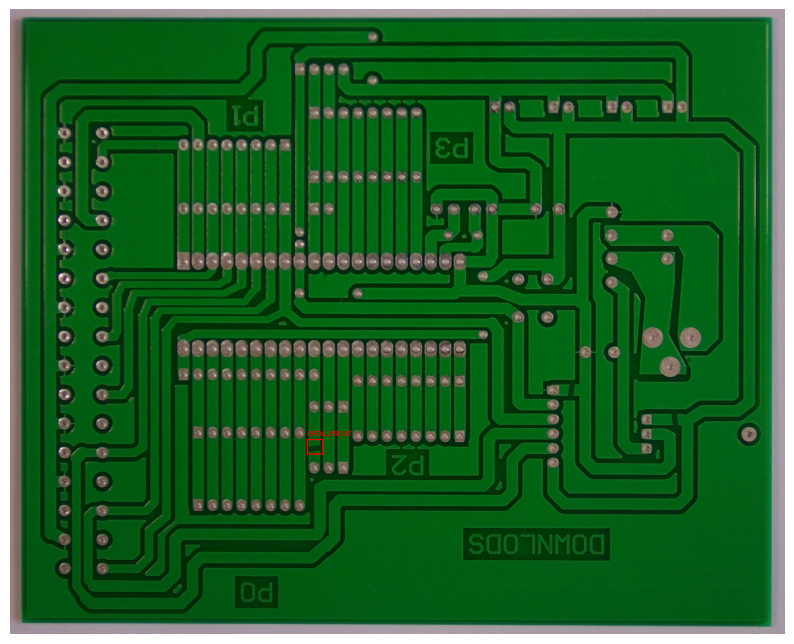

In [32]:
import cv2
import os
import random
from ultralytics import YOLO
import matplotlib.pyplot as plt

def generate_final_report(model_path, val_dir):
    model = YOLO(model_path)
    
    # Get a random image from the newly mixed validation set
    sample_img = os.path.join(val_dir, random.choice(os.listdir(val_dir)))
    
    results = model.predict(sample_img, conf=0.25, verbose=False)[0]
    img = cv2.imread(sample_img)
    
    print(f"\n📊 FINAL INDUSTRIAL INSPECTION: {os.path.basename(sample_img)}")
    print("=" * 65)
    print(f"{'Defect Detected':<18} | {'Center (X,Y)':<12} | {'Severity'}")
    print("-" * 65)

    if len(results.boxes) == 0:
        print("✅ STATUS: PASS (No defects found at 25% confidence)")
    else:
        for box in results.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            cx, cy = int((x1 + x2) / 2), int((y1 + y2) / 2)
            
            label = results.names[int(box.cls[0])]
            
            # Industrial Severity Logic
            if label in ['open_circuit', 'short', 'missing_hole']:
                severity, color = "CRITICAL", (0, 0, 255) # Red
            else:
                severity, color = "MEDIUM", (0, 255, 255) # Yellow

            print(f"{label:<18} | ({cx:>4}, {cy:>4}) | {severity}")
            
            # Annotate
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 4)
            cv2.putText(img, f"{label.upper()}", (x1, y1-15), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Run the report
BEST_MODEL_PATH = '/kaggle/working/task2_real_world/industrial_pcb_model2/weights/best.pt'
VAL_IMAGES = '/kaggle/working/pcb_real_world/images/val'
generate_final_report(BEST_MODEL_PATH, VAL_IMAGES)

# per class metrics


In [33]:
from ultralytics import YOLO
import pandas as pd

# 1. Load the best weights from your recent shuffled training
model_path = '/kaggle/working/task2_real_world/industrial_pcb_model2/weights/best.pt'
model = YOLO(model_path)

# 2. Run validation to get metrics
# We use verbose=False to keep the output clean, we will format it ourselves
metrics = model.val(data='/kaggle/working/pcb_real.yaml', split='val', verbose=False)

# 3. Extract per-class data
# metrics.names is a dict of class names {0: 'mouse_bite', ...}
# metrics.maps is a list of mAP50-95 for each class
class_results = []
for i, name in model.names.items():
    # Get precision, recall, mAP50, and mAP50-95 for each specific class
    # metrics.class_result(i) returns [P, R, mAP50, mAP95]
    p, r, ap50, ap95 = metrics.class_result(i)
    
    class_results.append({
        "Defect Type": name,
        "Precision": f"{p:.3f}",
        "Recall": f"{r:.3f}",
        "mAP50": f"{ap50:.3f}",
        "mAP50-95": f"{ap95:.3f}"
    })

# 4. Create and display a clean table
df = pd.DataFrame(class_results)
print("\n📋 PER-CLASS PERFORMANCE METRICS")
print("=" * 65)
print(df.to_string(index=False))
print("=" * 65)

# 5. Save the report for your submission zip
df.to_csv("/kaggle/working/per_class_metrics.csv", index=False)
print("💾 Per-class metrics saved to 'per_class_metrics.csv'")

Ultralytics 8.3.251 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4533.1±1094.6 MB/s, size: 1381.0 KB)
val: Scanning /kaggle/working/pcb_real_world/labels/val.cache... 139 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 139/139 275.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.1it/s 4.3s0.2ss
                   all        139        588      0.774      0.664      0.715      0.331
Speed: 4.5ms preprocess, 7.3ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to /kaggle/working/runs/detect/val

📋 PER-CLASS PERFORMANCE METRICS
    Defect Type Precision Recall mAP50 mAP50-95
     mouse_bite     0.608  0.505 0.568    0.227
           spur     0.793  0.663 0.711    0.322
   open_circuit     0.658  0.626 0.650    0.240
          short   

# Visual confirmation - Visual Checks

🔍 Searching for visual examples of each class in validation set...


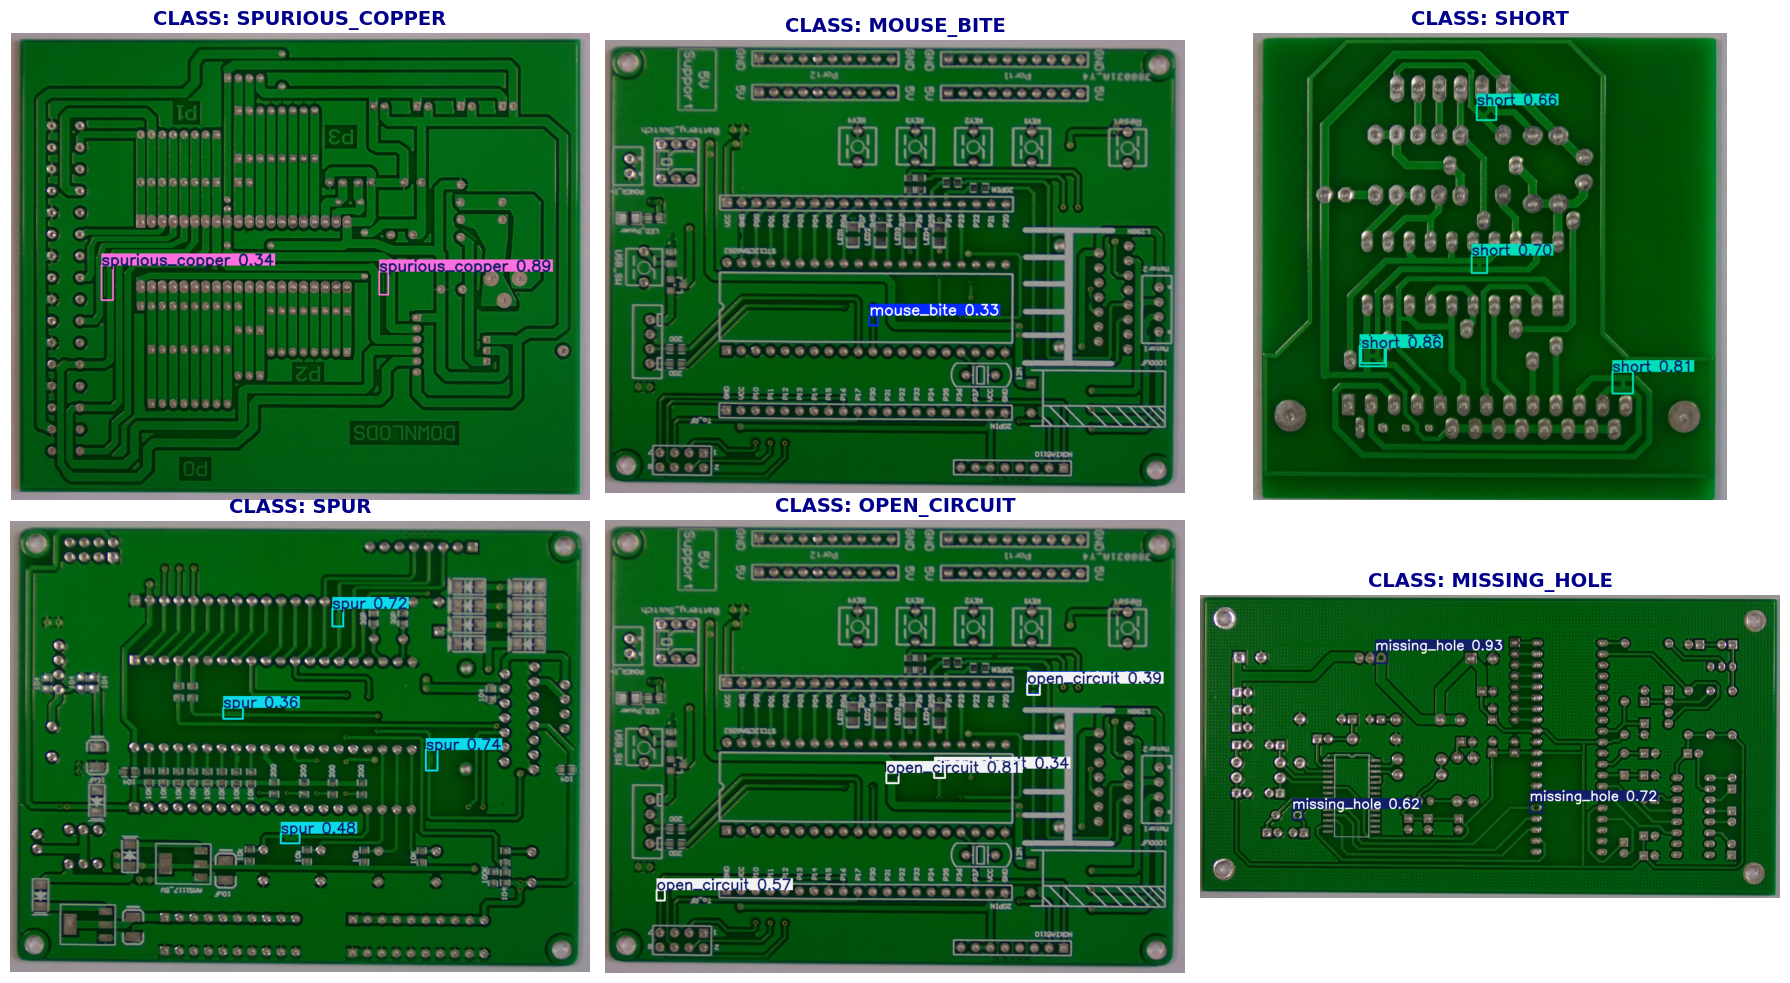

In [34]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os

# 1. Configuration
MODEL_PATH = '/kaggle/working/task2_real_world/industrial_pcb_model2/weights/best.pt'
VAL_DIR = '/kaggle/working/pcb_real_world/images/val'
model = YOLO(MODEL_PATH)

# Classes we want to find examples for
target_classes = ['mouse_bite', 'spur', 'open_circuit', 'short', 'missing_hole', 'spurious_copper']
examples = {}

print("🔍 Searching for visual examples of each class in validation set...")

# 2. Search through validation images until we find one example of each class
for img_name in os.listdir(VAL_DIR):
    if len(examples) == len(target_classes):
        break # Stop if we found all 6
        
    img_path = os.path.join(VAL_DIR, img_name)
    results = model.predict(img_path, conf=0.3, verbose=False)[0]
    
    for box in results.boxes:
        cls_id = int(box.cls[0])
        label = results.names[cls_id]
        
        if label in target_classes and label not in examples:
            # Found a new class example!
            examples[label] = results.plot() # Save the image with box drawn

# 3. Display the Gallery
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (label, img_data) in enumerate(examples.items()):
    axes[i].imshow(cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f"CLASS: {label.upper()}", fontsize=14, fontweight='bold', color='darkblue')
    axes[i].axis('off')

# If we didn't find all examples in the val set, hide the empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

if len(examples) < len(target_classes):
    missing = set(target_classes) - set(examples.keys())
    print(f"⚠️ Note: Some classes weren't found in the first few validation images: {missing}")

🔍 Capturing visual evidence for all 6 industrial classes...
✅ Gallery saved successfully: /kaggle/working/industrial_defect_gallery.png


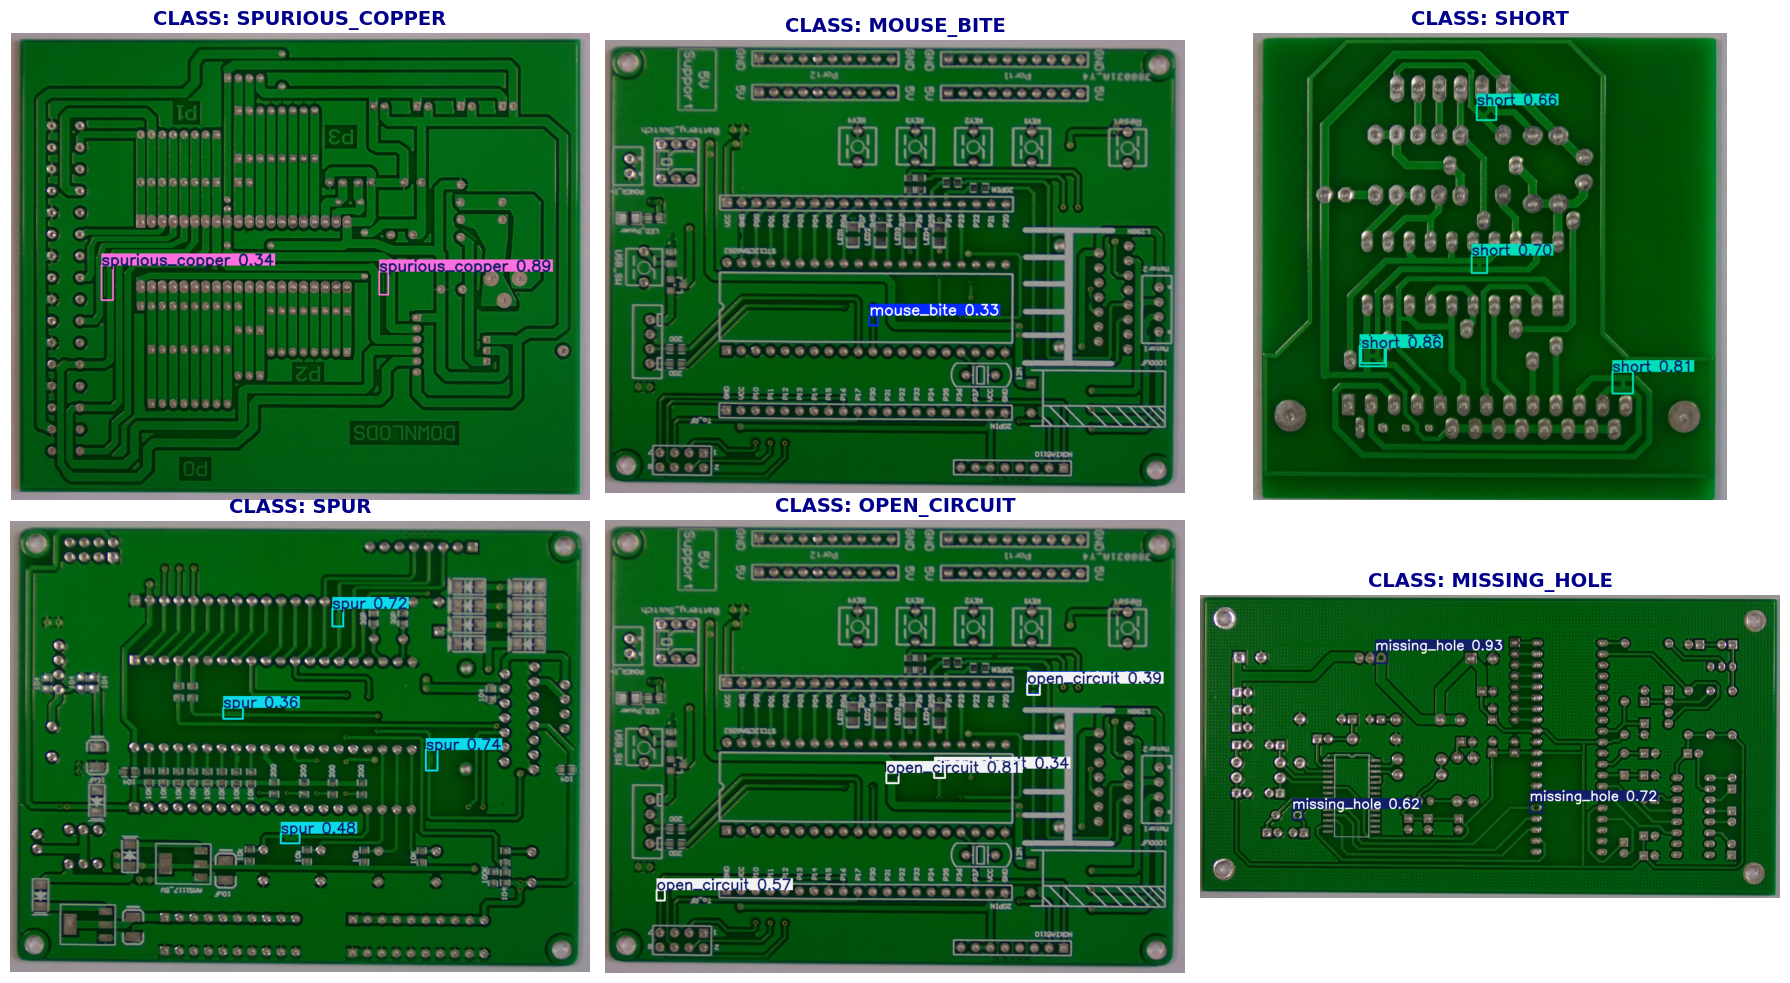

In [35]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os

# 1. Configuration
MODEL_PATH = '/kaggle/working/task2_real_world/industrial_pcb_model2/weights/best.pt'
VAL_DIR = '/kaggle/working/pcb_real_world/images/val'
model = YOLO(MODEL_PATH)

target_classes = ['mouse_bite', 'spur', 'open_circuit', 'short', 'missing_hole', 'spurious_copper']
examples = {}

print("🔍 Capturing visual evidence for all 6 industrial classes...")

# 2. Iterate and find best examples
for img_name in os.listdir(VAL_DIR):
    if len(examples) == len(target_classes):
        break
        
    img_path = os.path.join(VAL_DIR, img_name)
    results = model.predict(img_path, conf=0.3, verbose=False)[0]
    
    for box in results.boxes:
        cls_id = int(box.cls[0])
        label = results.names[cls_id]
        if label in target_classes and label not in examples:
            examples[label] = results.plot()

# 3. Create the Plot
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (label, img_data) in enumerate(examples.items()):
    axes[i].imshow(cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f"CLASS: {label.upper()}", fontsize=14, fontweight='bold', color='darkblue')
    axes[i].axis('off')

plt.tight_layout()

# 4. SAVE THE IMAGE FOR DOWNLOAD
output_path = "/kaggle/working/industrial_defect_gallery.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✅ Gallery saved successfully: {output_path}")

plt.show()


🚀 PCB INSPECTION REPORT: 11_missing_hole_10.jpg
-----------------------------------------------------------------
Defect Type        | Center (X,Y) | Severity
-----------------------------------------------------------------
missing_hole       | ( 856,  999) | CRITICAL
missing_hole       | (1458, 1508) | CRITICAL
missing_hole       | ( 343,  777) | CRITICAL
missing_hole       | ( 995,  784) | CRITICAL
missing_hole       | ( 648, 1482) | CRITICAL


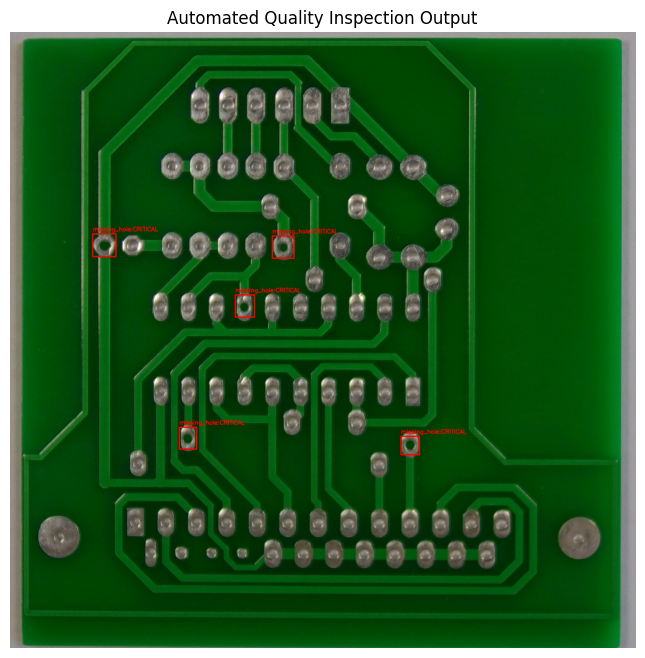

-----------------------------------------------------------------
💾 Result saved as 'final_inspection_result.jpg'


In [26]:
import cv2
import os
import random
from ultralytics import YOLO
import matplotlib.pyplot as plt

def run_industrial_report(image_path, model_path):
    # 1. Load the trained model
    model = YOLO(model_path)
    
    # 2. Run inference
    results = model.predict(image_path, conf=0.25, verbose=False)[0]
    img = cv2.imread(image_path)
    
    print(f"\n🚀 PCB INSPECTION REPORT: {os.path.basename(image_path)}")
    print("-" * 65)
    print(f"{'Defect Type':<18} | {'Center (X,Y)':<12} | {'Severity'}")
    print("-" * 65)

    if len(results.boxes) == 0:
        print("✅ PASS: No defects detected.")
    else:
        for box in results.boxes:
            # Get Bounding Box Pixels
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            
            # 3. Calculate Center (Requirement 3.4)
            cx = int((x1 + x2) / 2)
            cy = int((y1 + y2) / 2)
            
            # 4. Classify and Assess Severity (Requirement 3.4)
            cls_id = int(box.cls[0])
            label = results.names[cls_id]
            
            # Logic: Function-critical defects are 'CRITICAL'
            if label in ['open_circuit', 'short', 'missing_hole']:
                severity = "CRITICAL"
                color = (0, 0, 255) # Red
            else:
                severity = "MEDIUM"
                color = (0, 255, 255) # Yellow

            print(f"{label:<18} | ({cx:>4}, {cy:>4}) | {severity}")
            
            # Visuals for GitHub
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 3)
            cv2.putText(img, f"{label}:{severity}", (x1, y1-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

    # Display the result
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Automated Quality Inspection Output")
    plt.axis('off')
    plt.show()
    
    cv2.imwrite("final_inspection_result.jpg", img)
    print("-" * 65)
    print("💾 Result saved as 'final_inspection_result.jpg'")

# Execute on a sample from the val set
VAL_DIR = "/kaggle/working/pcb_real_world/images/val"
sample_file = os.path.join(VAL_DIR, random.choice(os.listdir(VAL_DIR)))
BEST_MODEL = "/kaggle/working/task2_real_world/industrial_pcb_model/weights/best.pt"

run_industrial_report(sample_file, BEST_MODEL)

In [27]:
import shutil
import os

# 1. Create a clean submission folder
submission_folder = "/kaggle/working/Sapien_Robotics_Task2_Submission"
os.makedirs(submission_folder, exist_ok=True)

# 2. Paths to the files we need to include
best_weights = "/kaggle/working/task2_real_world/industrial_pcb_model/weights/best.pt"
final_image = "/kaggle/working/final_inspection_result.jpg"
data_yaml = "/kaggle/working/pcb_real.yaml"

# 3. Copy files to the submission folder
if os.path.exists(best_weights):
    shutil.copy(best_weights, os.path.join(submission_folder, "best_pcb_model.pt"))

if os.path.exists(final_image):
    shutil.copy(final_image, os.path.join(submission_folder, "sample_inspection_output.jpg"))

if os.path.exists(data_yaml):
    shutil.copy(data_yaml, os.path.join(submission_folder, "dataset_config.yaml"))

# 4. Create the final ZIP
shutil.make_archive("Task2_Sapien_Robotics_Final", 'zip', submission_folder)

print("✅ SUCCESS: Your final submission ZIP has been created!")
print("🔗 Download 'Task2_Sapien_Robotics_Final.zip' from the Output tab on the right sidebar.")

✅ SUCCESS: Your final submission ZIP has been created!
🔗 Download 'Task2_Sapien_Robotics_Final.zip' from the Output tab on the right sidebar.



image 1/1 /kaggle/working/pcb_real_world/images/val/09_missing_hole_02.jpg: 512x640 (no detections), 6.7ms
Speed: 2.7ms preprocess, 6.7ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


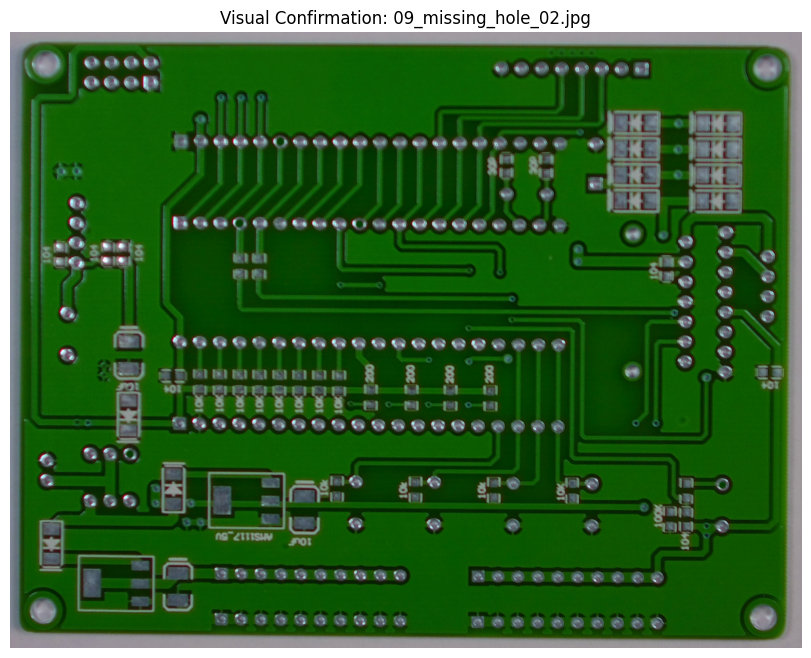

Detected 0 defects.


In [29]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os

# 1. Load the specific model you provided
MODEL_PATH = '/kaggle/input/yoloon-synth/pytorch/default/1/yolo_pcb_model.pt'
model = YOLO(MODEL_PATH)

# 2. Pick a known image from your real-world validation set
# We'll pick '04_short_03.jpg' since we verified its label exists earlier
sample_image = '/kaggle/working/pcb_real_world/images/val/04_short_03.jpg'

if not os.path.exists(sample_image):
    # Fallback: pick any file from the val directory
    val_files = os.listdir('/kaggle/working/pcb_real_world/images/val')
    sample_image = os.path.join('/kaggle/working/pcb_real_world/images/val', val_files[0])

# 3. Run Inference
results = model.predict(sample_image, conf=0.20)[0] # Lowered conf slightly for testing
img = cv2.imread(sample_image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 4. Plotting
plt.figure(figsize=(12, 8))
plt.imshow(results.plot()) # .plot() draws boxes and labels automatically
plt.title(f"Visual Confirmation: {os.path.basename(sample_image)}")
plt.axis('off')
plt.show()

# Print the text report for coordinate verification
print(f"Detected {len(results.boxes)} defects.")
for box in results.boxes:
    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
    cx, cy = int((x1+x2)/2), int((y1+y2)/2)
    cls = int(box.cls[0])
    label = results.names[cls]
    print(f"Target: {label} | Center: ({cx}, {cy}) | Conf: {float(box.conf[0]):.2f}")